# Big Data y Machine Learning (UBA) -  2025

## Trabajo Práctico 1: Jugando con APIs y WebScraping 

### Reglas de formato y presentación
- El trabajo debe estar debidamente documentado comentado (utilizando #) para que tanto los docentes como sus compañeros puedan comprender el código fácilmente.

- El mismo debe ser completado en este Jupyter Notebook y entregado como tal, es decir en un archivo .ipynb


### Fecha de entrega:
<font color=red>Viernes 5 de Septiembre a las 13:00 hs</font> 

### Modalidad de entrega
- Al finalizar el trabajo práctico deben hacer un último <i>commit</i> en su repositorio de GitHub llamado “Entrega final del tp”. 
- Asegurense de haber creado una carpeta llamada TP1. Este Jupyter Notebook y el correspondiente al TP1 deben estar dentro de esa carpeta.
- También deben enviar el link de su repositorio -para que pueda ser clonado y corregido- a mi correo 25RO35480961@campus.economicas.uba.ar. Usar de asunto de email <i>"Big Data - TP 1 - Grupo #"</i> y nombrar el archivo <i>"TP1_Grupo #"</i> donde # es el número de grupo que le fue asignado.
- La última versión en el repositorio es la que será evaluada. Por lo que es importante que: 
    - No envien el correo hasta no haber terminado y estar seguros de que han hecho el <i>commit y push</i> a la versión final que quieren entregar. 
    - No hagan nuevos <i>push</i> despues de haber entregado su versión final. Esto generaría confusión acerca de que versión es la que quieren que se les corrija.
- En resumen, la carpeta del repositorio debe incluir:
    - El codigo
    - Un documento Word (Parte A) donde esten las figuras y una breve descripción de las mismas.
    - El excel con los links webscrappeados (Parte B)

#### Ejercicio 1 - Jugando con APIs
Usando la API del Series de Tiempo de la Republica Argentina [link](https://datosgobar.github.io/series-tiempo-ar-api/applications/) , obtener dos series de indicadores del Ministerio de Agricultura, Ganadería y Pesca. En total, dicho Ministerio tiene 72 series anuales y pueden buscar dos serie de indicadores de su interés.

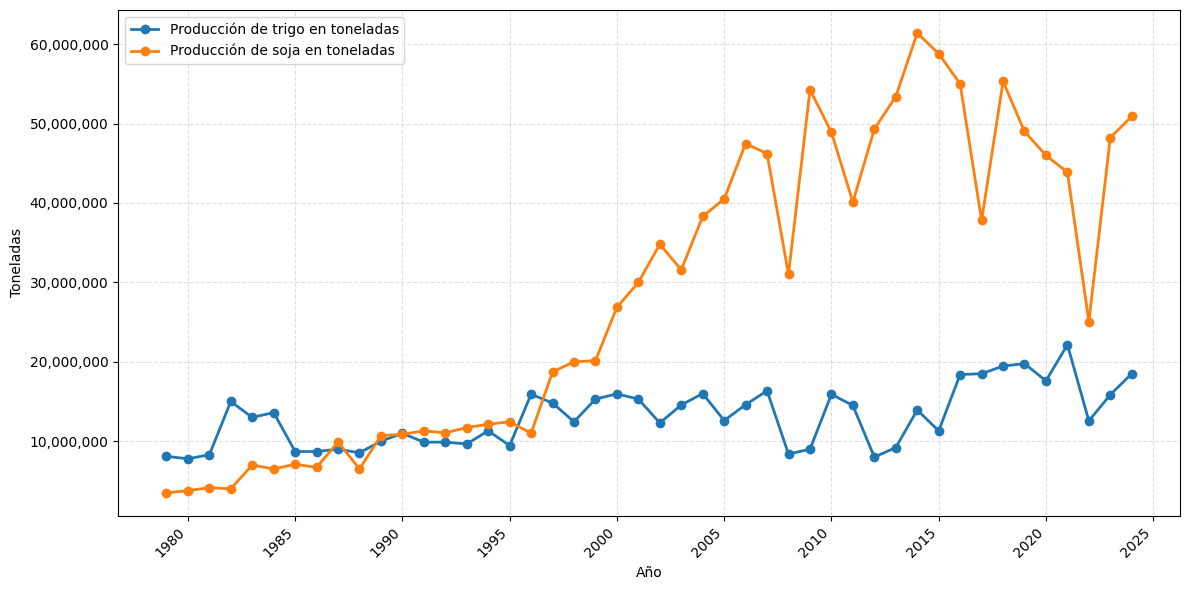

primeras filas:
            Producción de trigo en toneladas  Producción de soja en toneladas
fecha                                                                        
1979-01-01                         8100000.0                        3500000.0
1980-01-01                         7780000.0                        3770000.0
1981-01-01                         8300000.0                        4150000.0
1982-01-01                        15000000.0                        4000000.0
1983-01-01                        13000000.0                        7000000.0
1984-01-01                        13600000.0                        6500000.0
1985-01-01                         8700000.0                        7100000.0
1986-01-01                         8700000.0                        6700000.0
1987-01-01                         9000000.0                        9900000.0
1988-01-01                         8540000.0                        6500000.0


In [1]:
# importo las librerías
import requests
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from pathlib import Path

# URL
url = "https://apis.datos.gob.ar/series/api/series?ids=34.2_TTTRI_0_P_17,34.2_STSOJ_0_P_16"

# descargo la respuesta
r = requests.get(url, timeout=30)
r.raise_for_status()
j = r.json()

# preparo la carpeta de salidas
out_dir = Path("salidas_tp1")
out_dir.mkdir(exist_ok=True)

# construyo el DataFrame robusto para ambos formatos de la API
def construir_df(j):
    # si la API vino en formato series: j["data"]={"index":[...],"values":[...]}
    if isinstance(j.get("data"), dict) and {"index","values"} <= set(j["data"].keys()):
        fechas = pd.to_datetime(j["data"]["index"], errors="coerce")
        ids = j.get("params", {}).get("ids", [])
        if isinstance(ids, str):
            ids = [s.strip() for s in ids.split(",")]
        df = pd.DataFrame(index=fechas)
        for i, sid in enumerate(ids):
            df[sid] = pd.to_numeric(pd.Series(j["data"]["values"][i], index=fechas), errors="coerce")
        return df
    # si la API vino en formato tabla: j["data"] = lista de filas
    elif isinstance(j.get("data"), list):
        tabla = pd.DataFrame(j["data"])
        if tabla.empty:
            raise ValueError("la respuesta no tiene datos")
        tabla.iloc[:, 0] = pd.to_datetime(tabla.iloc[:, 0], errors="coerce")
        ids = j.get("params", {}).get("ids", [])
        if isinstance(ids, str):
            ids = [s.strip() for s in ids.split(",")]
        if len(ids) == tabla.shape[1] - 1:
            columnas = ["fecha"] + ids
        else:
            columnas = ["fecha"] + [f"serie_{i}" for i in range(1, tabla.shape[1])]
        tabla.columns = columnas
        return tabla.set_index("fecha").apply(pd.to_numeric, errors="coerce")
    else:
        raise ValueError("no reconozco el formato de la respuesta")

df = construir_df(j).sort_index().dropna(how="all")

# renombro columnas a nombres legibles si corresponden
nombres = {
    "34.2_TTTRI_0_P_17": "Producción de trigo en toneladas",
    "34.2_STSOJ_0_P_16": "Producción de soja en toneladas",
}
df = df.rename(columns={k: v for k, v in nombres.items() if k in df.columns})

# guardo los datos a Excel
excel_path = out_dir / "series_trigo_soja.xlsx"
with pd.ExcelWriter(excel_path, engine="openpyxl") as xw:
    df.to_excel(xw, sheet_name="series", index_label="fecha")

# genero el gráfico combinado
plt.figure(figsize=(12, 6))
ax = plt.gca()
for col in df.columns:
    ax.plot(df.index, df[col], marker="o", linewidth=2, label=col)
ax.grid(True, linestyle="--", alpha=0.4)
ax.set_xlabel("Año")
ax.set_ylabel("Toneladas")
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_ha("right")
ax.legend(loc="upper left")
plt.tight_layout()

png_path = out_dir / "produccion_trigo_soja.png"
plt.savefig(png_path, dpi=150)
plt.show()

print("primeras filas:")
print(df.head(10))


#### Ejercicio 2 - Repaso de Pandas
Realicen una estadistica descriptiva ambas series de indicadores del Ministerio de Ganaderia y  presente en una tabla en su reporte. Dicha tabla debe mostrar: numero de observaciones, media, desvío standard, min, p25, mediana, p75 y max. Comente la tabla en **el reporte**.

In [2]:
# calculo la estadística descriptiva pedida para el Ejercicio 2 usando el df ya creado
pd.options.display.float_format = '{:,.2f}'.format

resumen = pd.DataFrame({
    "n": df.count(),
    "media": df.mean(),
    "desvio_std": df.std(),
    "min": df.min(),
    "p25": df.quantile(0.25),
    "mediana": df.median(),
    "p75": df.quantile(0.75),
    "max": df.max(),
}).loc[df.columns]  # mantengo el orden de las columnas

# muestro la tabla en pantalla
print("tabla de resumen para el Ejercicio 2:")
print(resumen)

# guardo los archivos para incluir en el informe en Word
ej2_excel = out_dir / "tp1_ej2_resumen.xlsx"
ej2_csv = out_dir / "tp1_ej2_resumen.csv"
with pd.ExcelWriter(ej2_excel, engine="openpyxl") as xw:
    resumen.to_excel(xw, sheet_name="resumen", index=True)
resumen.to_csv(ej2_csv, index=True)

#dejé el Excel con el resumen en: {ej2_excel.resolve()}
#dejé el CSV con el resumen en:   {ej2_csv.resolve()}")



tabla de resumen para el Ejercicio 2:
                                   n         media    desvio_std          min  \
Producción de trigo en toneladas  46 13,065,066.41  3,795,979.30 7,780,000.00   
Producción de soja en toneladas   46 28,547,686.13 19,049,900.03 3,500,000.00   

                                           p25       mediana           p75  \
Producción de trigo en toneladas  9,498,386.25 12,800,000.00 15,888,287.50   
Producción de soja en toneladas  10,897,722.50 28,432,000.00 47,162,250.00   

                                           max  
Producción de trigo en toneladas 22,150,000.00  
Producción de soja en toneladas  61,400,000.00  


#### Ejercicio 3 - Practicando con Matplotlib
Armen dos gráficos de tendencia distintos usando la librería Matplotlib (repasen Clase 3). Uno programandolo con el estilo *pyplot* y otro gráfico de estilo *orientada a objetos*.
Recuerde los principios de visualización de datos y comente dichas figuras en su reporte.

In [3]:
# Ejercicio 3 - Gráfico con estilo pyplot
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

plt.figure(figsize=(10,5))
plt.plot(df.index, df['Producción de trigo en toneladas'], label='Trigo')
plt.plot(df.index, df['Producción de soja en toneladas'], label='Soja')
plt.title('Producción anual de Trigo y Soja en Argentina (1979–2025)')
plt.xlabel('Año')
plt.ylabel('Millones de toneladas')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Formatear eje Y en millones de toneladas (sin notación científica)
ax = plt.gca()
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x/1e6:.0f}"))

plt.tight_layout()
plt.show()


In [4]:
# Ejercicio 3 - Gráfico con estilo orientado a objetos (más personalizado)
import matplotlib.dates as mdates
import pandas as pd

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(df.index, df['Producción de trigo en toneladas'], label='Trigo', linewidth=2.4, color='#1f77b4')
ax.plot(df.index, df['Producción de soja en toneladas'], label='Soja', linewidth=2.4, color='#ff7f0e')

ax.set_title('Producción anual de Trigo y Soja en Argentina (1979–2025)', fontsize=16, weight='bold', pad=12)
ax.set_xlabel('Año', fontsize=12)
ax.set_ylabel('Millones de toneladas', fontsize=12)

# Eje X: ticks cada 5 años si el índice es datetime
if pd.api.types.is_datetime64_any_dtype(df.index):
    ax.xaxis.set_major_locator(mdates.YearLocator(5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
else:
    ax.set_xticks(range(int(df.index.min()), int(df.index.max())+1, 5))
ax.tick_params(axis='x', rotation=45)

# Eje Y en millones de toneladas
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x/1e6:.0f}"))

# Estética: grilla sutil, fondo blanco, leyenda destacada
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(frameon=True, facecolor='white', edgecolor='gray', fontsize=11)
fig.patch.set_facecolor('whitesmoke')
ax.set_facecolor('white')

fig.tight_layout()
plt.show()


### Parte B

#### Ejercicio 4 - Documentando noticias locales y en el extranjero
Eligan dos sitios web de noticias: uno de Argentina y uno del extranjero (puede ser en castellano o en inglés como el *New York Times*).

Utilicen herramientas de webscraping para obtener los **links** de las noticias de la portada en ambos diarios. Guarden cada titular con los links obtenidos en un dataframe. Por lo tanto, debe quedarles un dataframe de 4 columnas: una columna para noticias locales, otra para su link, otra columna de noticias extranjeras y una ultima columna de sus links. Luego, expórtenlo a un archivo de excel.

En el reporte este esta parte B:
1) Inserten una captura de pantalla de la pagina del diario extranjero y en Argentina de las cuales hacen el ejercicio de extraer titulares y sus links correspondientes. Esto servirá al momento de la corrección para verificar que los links obtenidos hacen referencia a las noticias de ese día y hora.
2) Comenten brevemente (1 párrafo) las diferencias/similitudes al extraer titulares en diarios de Argentina versus diario extranjero
3) Comenten brevemente (1 párrafo) las dificultades y cómo resolvieron dichas dificultades.

*Nota*: es posible que logren obtener los links a las noticias sin el dominio: por ejemplo "https://www.lanacion.com.ar/". De ser así, concatenen el dominio a la ruta del link obtenido, tal que se obtenga un link al que se pueda acceder. Es decir, que las cadenas de caracteres finales tendrán la forma: https://www.lanacion.com.ar/*texto_obtenido*)

---


Comenzamos con el codigo para ello en un primer momento importamos las librerias necesarias para el desarrollo del ejercicio

In [5]:
# Comienzo del Codigo
import requests #html requestor
from bs4 import BeautifulSoup #html parser
import pandas as pd #dataframe manipulator



Para nuestro webscrappeo vamos a elegir dos diarios, uno Argentino y uno Estado unidense. Uno sera "ambito financiero" y el otro "the economist"    

![Portada The economist](descarga.png)

![Portada Ámbito Financiero](5ede343e2e642__838x390.jpg)




Comenzamos por la traer el URL y html

In [6]:
url = "https://www.economist.com/"

url1 = "https://www.ambito.com/"
#En el diario en español hacemos un paso adicional dado que el servidor bloquea los request que no tienen un user-agent. mas explicado en el markdown
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "  
                  "AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/114.0.0.0 Safari/537.36"
}

r = requests.get(url) #traigo el contenido del html para diario en ingles
contenido = r.content

r1 = requests.get(url1, headers=headers) # traigo el contenido del html para diario en español
contenido1 = r1.content

if r1.status_code == 200:
    html1 = r1.text
    print("✅ HTML descargado correctamente")
else:
    print(f"❌ Error {r1.status_code}")

#sopa
soup = BeautifulSoup(contenido, "html.parser")
soup1 = BeautifulSoup(contenido1, "html.parser")

# Mostrar los primeros 100 caracteres del HTML de ambos diarios
print("The Economist HTML:\n", soup.prettify()[:100])
print("\nÁmbito Financiero HTML:\n", soup1.prettify()[:100])

✅ HTML descargado correctamente
The Economist HTML:
 <!DOCTYPE html>
<html lang="en-US">
 <head>
  <title>
   Just a moment...
  </title>
  <meta content

Ámbito Financiero HTML:
 <!DOCTYPE html>
<!--[if lt IE 7]>  <html class="no-js lt-ie9 lt-ie8 lt-ie7"><![endif]-->
<!--[if IE 


Ahora buscamos los titulos, comenzemos por ambito financiero.

In [7]:
# Dentro de la sopa, busco los elementos que contienen la información que necesito en este caso los titulos y los links
# Buscar todos los elementos de título con la clase news-article__title
titulo_elements = soup1.find_all(['h1', 'h2', 'h3'], class_='news-article__title')
if titulo_elements:
    for titulo_element in titulo_elements:
        a_tag = titulo_element.find('a')
        if a_tag and 'href' in a_tag.attrs:
            print('Ambito:', a_tag.text.strip())
            print('Link:', a_tag['href'])

Ambito: Dólar sin libre flotación: cuál es el poder de fuego del Tesoro para intervenir y cuánto vendió tras el anuncio
Link: https://www.ambito.com/finanzas/dolar-libre-flotacion-cual-es-el-poder-fuego-del-tesoro-intervenir-y-cuanto-vendio-el-anuncio-n6185708
Ambito: Los bonos en dólares se hundieron hasta 3% tras el anuncio de intervención del Tesoro en el mercado cambiario
Link: https://www.ambito.com/finanzas/los-bonos-dolares-caen-el-wall-street-y-los-activos-argentinos-sufren-la-previa-electoral-n6185535
Ambito: El dólar oficial cayó $11 luego de la decisión del Gobierno de intervenir en la plaza cambiaria
Link: https://www.ambito.com/finanzas/el-dolar-oficial-cayo-11-luego-la-decision-del-gobierno-intervenir-la-plaza-cambiaria-n6185573
Ambito: Cristina cuestionó a Milei por las últimas medidas económicas: "Terminaste de quemar los libritos de la escuela Austríaca"
Link: https://www.ambito.com/politica/cristina-kirchner-cuestiono-javier-milei-las-ultimas-medidas-economicas-termin

Ahora pasemos todo a un dataframe

In [8]:
# Extraer títulos y links de h2 y guardarlos en listas
titulos = []
direccion = []

for element in titulo_elements:
    a_tag = element.find('a')
    if a_tag and 'href' in a_tag.attrs:
        titulos.append(a_tag.text.strip())
        direccion.append(a_tag['href'])

# Crear el dataframe
ambito_df = pd.DataFrame({'titular': titulos, 'direccion': direccion})


ambito_df.head()

,titular,direccion
0,Dólar sin libre flotación: cuál es el poder de...,https://www.ambito.com/finanzas/dolar-libre-fl...
1,Los bonos en dólares se hundieron hasta 3% tra...,https://www.ambito.com/finanzas/los-bonos-dola...
2,El dólar oficial cayó $11 luego de la decisión...,https://www.ambito.com/finanzas/el-dolar-ofici...
3,Cristina cuestionó a Milei por las últimas med...,https://www.ambito.com/politica/cristina-kirch...
4,Crisis política en el Gobierno: la trama de co...,https://www.ambito.com/politica/crisis-el-gobi...


In [9]:
#lo guardamos
ambito_df.to_excel("ambito_financiero.xlsx", index=False)

---

Ahora repliquemos lo mismo para the economist


In [ ]:
#-----------------------------# REPETIMOS
title_elements = soup1.find_all(['h1', 'h2', 'h3'], class_='css-ayljkz esjbanf0')
if title_elements:
    for title_element in title_elements:
        a_tag = title_element.find('a')
        if a_tag and 'href' in a_tag.attrs:
            print('economist:', a_tag.text.strip())
            print('Link:', a_tag['href'])


Como vemos para the economist no nos tira nada o tira error, investigando llegamos a la conclusion que the economist al igual que ambito financiero pone reestricciones para que no scrapeen su informacion. sin embargo existe un RSS OFICIAL, que es comun en medios de comunicacion grandes. Un RSS significa "Really simple syndication" Es un formato XML que usan los medios para publicar sus articulos de manera estandarizada. aca obtenemos  el titulo del articulo, el link, fecha y resumen (Aveces imagenes)

Para ello optamos por un camino alternativo veamos como hacerlo:

In [11]:
%pip install feedparser

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
import feedparser # Librería para analizar un RSS

# RSS feed de The Economist (Economics / Finance & Economics)
URL = "https://www.economist.com/finance-and-economics/rss.xml"

# Interpreta el RSS
feed = feedparser.parse(URL)

print("Título del feed:", feed.feed.title)
print("Link del feed:", feed.feed.link)
print("Cantidad de artículos:", len(feed.entries))
print("-" * 50)

# Recorrer artículos
for entry in feed.entries[:]:  # que recorra todos los titulos
    print("Título:", entry.title)
    print("Link:", entry.link)
    print("Publicado:", entry.published)
    print("Resumen:", entry.summary[:200], "...")
    print("-" * 50)


Título del feed: Finance & economics
Link del feed: https://www.economist.com/finance-and-economics
Cantidad de artículos: 300
--------------------------------------------------
Título: China turns crypto-curious
Link: https://www.economist.com/finance-and-economics/2025/09/02/china-turns-crypto-curious
Publicado: Tue, 02 Sep 2025 17:55:48 +0000
Resumen: But would the country’s leaders really want stablecoins to succeed? ...
--------------------------------------------------
Título: America is escaping its office crisis
Link: https://www.economist.com/finance-and-economics/2025/09/01/america-is-escaping-its-office-crisis
Publicado: Mon, 01 Sep 2025 19:20:16 +0000
Resumen: The torment caused by covid-19 and high interest rates appears to be over ...
--------------------------------------------------
Título: The threat of deflation stalks Asia’s economies
Link: https://www.economist.com/finance-and-economics/2025/09/01/the-threat-of-deflation-stalks-asias-economies
Publicado: Mon, 01 Sep

In [13]:
# Extraer títulos y links de h2 y guardarlos en listas
titles = []
links = []

for entry in feed.entries:
        titles.append (entry.title)
        links.append(entry.link)

# Crear el dataframe
economist_df = pd.DataFrame({'title': titles, 'link': links})


economist_df.head()


,title,link
0,China turns crypto-curious,https://www.economist.com/finance-and-economic...
1,America is escaping its office crisis,https://www.economist.com/finance-and-economic...
2,The threat of deflation stalks Asia’s economies,https://www.economist.com/finance-and-economic...
3,Trump’s interest-rate crusade will be self-def...,https://www.economist.com/finance-and-economic...
4,"Gambling or investing? In America, the line is...",https://www.economist.com/finance-and-economic...


In [14]:
#lo guardamos
economist_df.to_excel("economist.xlsx", index=False)


Ahora concatenamos ambos data frames. Agarramos las primeras 100 filas. debido que en ambito tenemos 100 filas y en the economist 300 .

In [15]:
# Filtrar solo las primeras 100 filas del DataFrame
economist_df_100 = economist_df[["title", "link"]].head(100).copy()
ambito_df_100 = ambito_df[["titular", "direccion"]].head(100).copy()

#muestro ambos df
display(ambito_df_100)
display(economist_df_100)



,titular,direccion
0,Dólar sin libre flotación: cuál es el poder de...,https://www.ambito.com/finanzas/dolar-libre-fl...
1,Los bonos en dólares se hundieron hasta 3% tra...,https://www.ambito.com/finanzas/los-bonos-dola...
2,El dólar oficial cayó $11 luego de la decisión...,https://www.ambito.com/finanzas/el-dolar-ofici...
3,Cristina cuestionó a Milei por las últimas med...,https://www.ambito.com/politica/cristina-kirch...
4,Crisis política en el Gobierno: la trama de co...,https://www.ambito.com/politica/crisis-el-gobi...
...,...,...
95,"""Nueve Auras"": un documental que homenajea el ...",https://www.ambito.com/espectaculos/nueve-aura...
96,El Colegio de Abogados repudió al juez que dic...,https://www.ambito.com/politica/el-colegio-abo...
97,El INDEC continúa demorando la adopción del nu...,https://www.ambito.com/negocios/el-indec-conti...
98,Nestlé despidió a su CEO por mantener una rela...,https://www.ambito.com/mundo/nestle-despidio-s...


,title,link
0,China turns crypto-curious,https://www.economist.com/finance-and-economic...
1,America is escaping its office crisis,https://www.economist.com/finance-and-economic...
2,The threat of deflation stalks Asia’s economies,https://www.economist.com/finance-and-economic...
3,Trump’s interest-rate crusade will be self-def...,https://www.economist.com/finance-and-economic...
4,"Gambling or investing? In America, the line is...",https://www.economist.com/finance-and-economic...
...,...,...
95,How might China win the future? Ask Google’s AI,https://www.economist.com/finance-and-economic...
96,The courts block Trump’s tariffs. Can he circu...,https://www.economist.com/finance-and-economic...
97,Shareholders face a big new problem: currency ...,https://www.economist.com/finance-and-economic...
98,Why AI hasn’t taken your job,https://www.economist.com/finance-and-economic...


In [16]:
df_final= pd.concat([economist_df_100, ambito_df_100], ignore_index=True)
df_final.reset_index(drop=True, inplace=True)
df_final

,title,link,titular,direccion
0,China turns crypto-curious,https://www.economist.com/finance-and-economic...,NaN,NaN
1,America is escaping its office crisis,https://www.economist.com/finance-and-economic...,NaN,NaN
2,The threat of deflation stalks Asia’s economies,https://www.economist.com/finance-and-economic...,NaN,NaN
3,Trump’s interest-rate crusade will be self-def...,https://www.economist.com/finance-and-economic...,NaN,NaN
4,"Gambling or investing? In America, the line is...",https://www.economist.com/finance-and-economic...,NaN,NaN
...,...,...,...,...
195,NaN,NaN,"""Nueve Auras"": un documental que homenajea el ...",https://www.ambito.com/espectaculos/nueve-aura...
196,NaN,NaN,El Colegio de Abogados repudió al juez que dic...,https://www.ambito.com/politica/el-colegio-abo...
197,NaN,NaN,El INDEC continúa demorando la adopción del nu...,https://www.ambito.com/negocios/el-indec-conti...
198,NaN,NaN,Nestlé despidió a su CEO por mantener una rela...,https://www.ambito.com/mundo/nestle-despidio-s...


In [17]:
# Asegurarse de que tengan el mismo índice
economist_df_100.reset_index(drop=True, inplace=True)
ambito_df_100.reset_index(drop=True, inplace=True)

# Combinar datos tomando los valores que no son nulos
df_final = economist_df_100.combine_first(ambito_df_100)

# Reordenar columnas: 'titular' al lado de 'direccion'
cols = ['direccion', 'titular', 'link', 'title']  # nuevo orden
df_final = df_final[cols]

# Renombrar 'titular' a 'titulo'
df_final.rename(columns={'titular': 'titulo'}, inplace=True)

df_final


,direccion,titulo,link,title
0,https://www.ambito.com/finanzas/dolar-libre-fl...,Dólar sin libre flotación: cuál es el poder de...,https://www.economist.com/finance-and-economic...,China turns crypto-curious
1,https://www.ambito.com/finanzas/los-bonos-dola...,Los bonos en dólares se hundieron hasta 3% tra...,https://www.economist.com/finance-and-economic...,America is escaping its office crisis
2,https://www.ambito.com/finanzas/el-dolar-ofici...,El dólar oficial cayó $11 luego de la decisión...,https://www.economist.com/finance-and-economic...,The threat of deflation stalks Asia’s economies
3,https://www.ambito.com/politica/cristina-kirch...,Cristina cuestionó a Milei por las últimas med...,https://www.economist.com/finance-and-economic...,Trump’s interest-rate crusade will be self-def...
4,https://www.ambito.com/politica/crisis-el-gobi...,Crisis política en el Gobierno: la trama de co...,https://www.economist.com/finance-and-economic...,"Gambling or investing? In America, the line is..."
...,...,...,...,...
95,https://www.ambito.com/espectaculos/nueve-aura...,"""Nueve Auras"": un documental que homenajea el ...",https://www.economist.com/finance-and-economic...,How might China win the future? Ask Google’s AI
96,https://www.ambito.com/politica/el-colegio-abo...,El Colegio de Abogados repudió al juez que dic...,https://www.economist.com/finance-and-economic...,The courts block Trump’s tariffs. Can he circu...
97,https://www.ambito.com/negocios/el-indec-conti...,El INDEC continúa demorando la adopción del nu...,https://www.economist.com/finance-and-economic...,Shareholders face a big new problem: currency ...
98,https://www.ambito.com/mundo/nestle-despidio-s...,Nestlé despidió a su CEO por mantener una rela...,https://www.economist.com/finance-and-economic...,Why AI hasn’t taken your job


In [19]:
df_final.to_excel("df_final1.xlsx", index=False) # lo guardamos
df_final.to_csv("df_final1.csv", index=False) # lo guardamos